In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Setup Pyspark**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/spark-3.0.0-bin-hadoop3.2.tgz

^C


In [ ]:
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=bfe776d2da33fdcea2a570623f0b6e381a9afd8ff3061f5a17bc831adc9962d8
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## **Import Library**

In [ ]:
import numpy as np
import zipfile
from google.colab import files
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

## **Preparing dataset from Kaggle**

In [ ]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Token API
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Receive dataset config
!chmod 600 /content/kaggle.json

In [ ]:
# Download dataset
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mssmartypants/water-quality

  0% 0.00/258k [00:00<?, ?B/s]
100% 258k/258k [00:00<00:00, 58.3MB/s]


In [ ]:
# extract dataset
local_zip = '/content/water-quality.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## **Dataset Information**

**Variables in the Dataset**

* aluminium - dangerous if greater than 2.8
* ammonia - dangerous if greater than 32.5
* arsenic - dangerous if greater than 0.01
* barium - dangerous if greater than 2
* cadmium - dangerous if greater than 0.005
* chloramine - dangerous if greater than 4
* chromium - dangerous if greater than 0.1
* copper - dangerous if greater than 1.3
* flouride - dangerous if greater than 1.5
* bacteria - dangerous if greater than 0
* viruses - dangerous if greater than 0
* lead - dangerous if greater than 0.015
* nitrates - dangerous if greater than 10
* nitrites - dangerous if greater than 1
* mercury - dangerous if greater than 0.002
* perchlorate - dangerous if greater than 56
* radium - dangerous if greater than 5
* selenium - dangerous if greater than 0.5
* silver - dangerous if greater than 0.1
* uranium - dangerous if greater than 0.3
* is_safe - class attribute {0 - not safe, 1 - safe}

In [ ]:
water = spark.read.csv('waterQuality1.csv', header=True, inferSchema=True)
water.show()

+---------+-------+-------+------+-------+----------+--------+------+--------+--------+-------+-----+--------+--------+-------+-----------+------+--------+------+-------+-------+
|aluminium|ammonia|arsenic|barium|cadmium|chloramine|chromium|copper|flouride|bacteria|viruses| lead|nitrates|nitrites|mercury|perchlorate|radium|selenium|silver|uranium|is_safe|
+---------+-------+-------+------+-------+----------+--------+------+--------+--------+-------+-----+--------+--------+-------+-----------+------+--------+------+-------+-------+
|     1.65|   9.08|   0.04|  2.85|  0.007|      0.35|    0.83|  0.17|    0.05|     0.2|    0.0|0.054|   16.08|    1.13|  0.007|      37.75|  6.78|    0.08|  0.34|   0.02|      1|
|     2.32|  21.16|   0.01|  3.31|  0.002|      5.28|    0.68|  0.66|     0.9|    0.65|   0.65|  0.1|    2.01|    1.93|  0.003|      32.26|  3.21|    0.08|  0.27|   0.05|      1|
|     1.01|  14.02|   0.04|  0.58|  0.008|      4.24|    0.53|  0.02|    0.99|    0.05|  0.003|0.078|   1

## **Data Preprocessing**

In [ ]:
# Count null and NaN value
water.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in water.columns]).show()

+---------+-------+-------+------+-------+----------+--------+------+--------+--------+-------+----+--------+--------+-------+-----------+------+--------+------+-------+-------+
|aluminium|ammonia|arsenic|barium|cadmium|chloramine|chromium|copper|flouride|bacteria|viruses|lead|nitrates|nitrites|mercury|perchlorate|radium|selenium|silver|uranium|is_safe|
+---------+-------+-------+------+-------+----------+--------+------+--------+--------+-------+----+--------+--------+-------+-----------+------+--------+------+-------+-------+
|        0|      0|      0|     0|      0|         0|       0|     0|       0|       0|      0|   0|       0|       0|      0|          0|     0|       0|     0|      0|      0|
+---------+-------+-------+------+-------+----------+--------+------+--------+--------+-------+----+--------+--------+-------+-----------+------+--------+------+-------+-------+



In [ ]:
water.printSchema()

root
 |-- aluminium: double (nullable = true)
 |-- ammonia: string (nullable = true)
 |-- arsenic: double (nullable = true)
 |-- barium: double (nullable = true)
 |-- cadmium: double (nullable = true)
 |-- chloramine: double (nullable = true)
 |-- chromium: double (nullable = true)
 |-- copper: double (nullable = true)
 |-- flouride: double (nullable = true)
 |-- bacteria: double (nullable = true)
 |-- viruses: double (nullable = true)
 |-- lead: double (nullable = true)
 |-- nitrates: double (nullable = true)
 |-- nitrites: double (nullable = true)
 |-- mercury: double (nullable = true)
 |-- perchlorate: double (nullable = true)
 |-- radium: double (nullable = true)
 |-- selenium: double (nullable = true)
 |-- silver: double (nullable = true)
 |-- uranium: double (nullable = true)
 |-- is_safe: string (nullable = true)



In [ ]:
# Convert tipe data kolom ammonia dari string ke double
water = water.withColumn("ammonia",water.ammonia.cast('double'))

In [ ]:
# Convert tipe data kolom is_safe dari string ke double
water = water.withColumn("is_safe",water.is_safe.cast('double'))

In [ ]:
water.printSchema()

root
 |-- aluminium: double (nullable = true)
 |-- ammonia: double (nullable = true)
 |-- arsenic: double (nullable = true)
 |-- barium: double (nullable = true)
 |-- cadmium: double (nullable = true)
 |-- chloramine: double (nullable = true)
 |-- chromium: double (nullable = true)
 |-- copper: double (nullable = true)
 |-- flouride: double (nullable = true)
 |-- bacteria: double (nullable = true)
 |-- viruses: double (nullable = true)
 |-- lead: double (nullable = true)
 |-- nitrates: double (nullable = true)
 |-- nitrites: double (nullable = true)
 |-- mercury: double (nullable = true)
 |-- perchlorate: double (nullable = true)
 |-- radium: double (nullable = true)
 |-- selenium: double (nullable = true)
 |-- silver: double (nullable = true)
 |-- uranium: double (nullable = true)
 |-- is_safe: double (nullable = true)



In [ ]:
# Retrieved 7000 data from the entire dataset
water = water.limit(7000)

In [ ]:
# View the number of datasets
rows = water.count()
print(f"Dataset berjumlah {rows} baris") # Dataset with {rows} rows

Dataset berjumlah 7000 baris


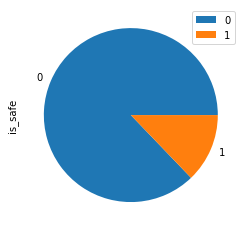

In [ ]:
water_df = water.toPandas()
piefreq = water_df['is_safe'].value_counts()
waterdf_piefreq = piefreq.reset_index()
fig = waterdf_piefreq.plot.pie(
    y="is_safe",
)

In [ ]:
# Accommodates independent columns in one variable
cols = water.columns[:-1]
cols = np.array(cols)
cols

array(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium',
       'chloramine', 'chromium', 'copper', 'flouride', 'bacteria',
       'viruses', 'lead', 'nitrates', 'nitrites', 'mercury',
       'perchlorate', 'radium', 'selenium', 'silver', 'uranium'],
      dtype='<U11')

In [ ]:
vecAssembler = VectorAssembler(inputCols = cols, outputCol = "features")
water = water.withColumnRenamed("is_safe","label")

water_df = vecAssembler.transform(water)
water_df = water_df.select(['features', 'label'])
water_df.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                    |label|
+------------------------------------------------------------------------------------------------------------+-----+
|[1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.2,0.0,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02]    |1.0  |
|[2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.9,0.65,0.65,0.1,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05]     |1.0  |
|[1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,0.003,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01]|0.0  |
|[1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,0.71,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05]   |1.0  |
|[0.92,24.33,0.03,0.2,0.006,2.67,0.69,0.57,0.61,0.13,0.001,0.117,6.74,1.11,0.003,16.9,2.41,0.02,0.06,0.02]   |1.0  |
|[0.94,14.47,0.03,2.88,0.003,0.8,0.43,1.38,0.11,0.67,0.67,0.135,

## **Modelling and evaluation**

**Modelling**

In [ ]:
# Split the data into train and test
splits = water_df.randomSplit([0.9, 0.1], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 20 (features), two intermediate of size 34 and 89
# and output of size 2 (classes)
layers = [20, 34, 89, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.9282576866764275


In [ ]:
result.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,4.32,0.04,0....|  0.0|[3.55751767561411...|[0.99813700705072...|       0.0|
|[0.0,4.89,0.04,0....|  0.0|[2.78834706299831...|[0.99062251826784...|       0.0|
|[0.0,9.82,0.68,0....|  0.0|[2.96563785175352...|[0.99368004688380...|       0.0|
|[0.0,10.19,0.06,0...|  1.0|[1.83771998278192...|[0.94191244002955...|       0.0|
|[0.0,11.26,0.0,0....|  0.0|[1.80692348654525...|[0.94492739859880...|       0.0|
|[0.0,12.31,0.1,0....|  0.0|[2.86078962048382...|[0.99339764459578...|       0.0|
|[0.0,13.74,0.01,1...|  0.0|[2.03491603013674...|[0.96059070477090...|       0.0|
|[0.0,14.25,0.02,1...|  0.0|[2.67169885568273...|[0.98889814019317...|       0.0|
|[0.0,14.38,0.86,1...|  0.0|[4.80921843475253...|[0.99985425565882...|       0.0|
|[0.0,14.45,0.07

**Evaluation**

In [ ]:
label = np.array(result.select("label").collect())
prediction = np.array(result.select("prediction").collect())

print(classification_report(label, prediction))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       589
         1.0       0.82      0.62      0.70        94

    accuracy                           0.93       683
   macro avg       0.88      0.80      0.83       683
weighted avg       0.92      0.93      0.92       683



In [ ]:
confusion_matrix(label, prediction)

array([[576,  13],
       [ 36,  58]])

**Prediction Test**

In [ ]:
predict1 = model.predict(Vectors.dense([3,40,0.2,3.2,0.009,6.22,0.5,1.86,2,0.16,0.1,0.2,14,2,0.01,60,7.24,0.65,0.1,0.5]))
if predict1 == 0:
  print('Air tidak aman dikonsumsi') # Water is not safe for consumption
else:
  print('Air aman dikonsumsi') # Water is safe for consumption

Air tidak aman dikonsumsi


In [ ]:
predict2 = model.predict(Vectors.dense([2,20,0.005,0.5,0.001,2,0.002,0.57,0.5,0,0,0.001,6.74,0.8,0.001,15,3,0.02,0.04,0.01]))
if predict1 == 0:
  print('Air tidak aman dikonsumsi') # Water is not safe for consumption
else:
  print('Air aman dikonsumsi') # Water is safe for consumption

Air aman dikonsumsi
